##**Text** **Classification** **With** **Pytorch**

In [ ]:
!pip install transformers --quiet
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection")

In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader , Dataset
from transformers import AutoTokenizer , AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Available device is:",device)

Available device is: cuda


In [4]:
data_df = pd.read_json("/content/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines=True)
data_df.dropna(inplace = True)
data_df.drop(["article_link"],inplace = True, axis = 1)
data_df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
X_train,X_test,y_train,y_test = train_test_split(np.array(data_df["headline"]),np.array(data_df["is_sarcastic"]),test_size = 0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size = 0.5)

print(X_train.shape[0])
print(X_test.shape[0])
print(X_val.shape[0])

18696
4007
4006


In [6]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = AutoModel.from_pretrained("google-bert/bert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [7]:
class dataset(Dataset):
  def __init__(self,X,Y):
    self.X = [tokenizer(x,
                       max_length = 100,
                       truncation = True,
                       padding = "max_length",
                       return_tensors = "pt",
                       ).to(device)
                       for x in X]

    self.Y = torch.tensor(Y,dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self,indx):
    return self.X[indx] , self.Y[indx]


In [8]:
train_data = dataset(X_train,y_train)
test_data = dataset(X_test,y_test)
val_data = dataset(X_val,y_val)

In [9]:
BATCH_SIZE =32
EPOCHS = 10
LR = 1e-4

In [10]:
train_dataloader = DataLoader(train_data,batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_data,batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_data,batch_size =BATCH_SIZE)

In [11]:
class Model(nn.Module):
  def __init__(self,bert):
    super(Model,self).__init__()

    self.bert = bert
    self.dropout = nn.Dropout(0,25)
    self.linear1 = nn.Linear(768,384)
    self.linear2 = nn.Linear(384,1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids ,attention_mask):
    pooled_output = self.bert(input_ids,attention_mask,return_dict = False)[0][:,0]
    output = self.linear1(pooled_output)
    output = self.dropout(output)
    output = self.linear2(output)
    output = self.sigmoid(output)
    return output

In [12]:
for param in bert_model.parameters():
  param.requires_grad = False
model = Model(bert_model).to(device)

In [13]:
model

Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [14]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(),lr = LR)

In [15]:
total_loss_train_plot = []
total_acc_train_plot = []
total_acc_val_plot = []
total_loss_val_plot = []

for epoch in range(EPOCHS):
  total_loss_train = 0
  total_loss_val = 0
  total_acc_train = 0
  total_acc_val = 0

  for index, data in enumerate(train_dataloader):
    inputs , labels = data
    inputs.to(device)
    labels.to(device)
    prediction = model(inputs["input_ids"].squeeze(1),inputs["attention_mask"].squeeze(1)).squeeze(1)
    batch_loss = criterion(prediction , labels)
    total_loss_train+=batch_loss.item()

    acc = (prediction.round() == labels).sum().item()
    total_acc_train += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad

  with torch.no_grad():
      for indx , data in enumerate(val_dataloader):
        inputs , labels = data
        inputs.to(device)
        labels.to(device)
        prediction = model(inputs["input_ids"].squeeze(1),inputs["attention_mask"].squeeze(1)).squeeze(1)
        batch_loss = criterion(prediction , labels)
        total_loss_val+=batch_loss.item()

        acc = (prediction.round() == labels).sum().item()
        total_acc_val+=acc

  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_val_plot.append(round(total_loss_val/1000,4))
  total_acc_train_plot.append(round((total_acc_train/train_data.__len__())*100,4))
  total_acc_val_plot.append(round((total_acc_val/val_data.__len__())*100,4))

  print(f"""Epoch {epoch+1}:
            Training Loss = {round(total_loss_train/1000,4)}
            Validation Loss = {round(total_loss_val/1000,4)}
            Training Accuracy = {round((total_acc_train/train_data.__len__())*100,4)}
            Validation Accuracy = {round((total_acc_val/val_data.__len__())*100,4)}
          """)

Epoch 1:
            Training Loss = 0.9472
            Validation Loss = 0.2333
            Training Accuracy = 63.3291
            Validation Accuracy = 71.4678
          
Epoch 2:
            Training Loss = 2.6662
            Validation Loss = 0.7723
            Training Accuracy = 67.9611
            Validation Accuracy = 72.9905
          
Epoch 3:
            Training Loss = 8.5388
            Validation Loss = 1.5576
            Training Accuracy = 74.6898
            Validation Accuracy = 77.9581
          
Epoch 4:
            Training Loss = 11.2502
            Validation Loss = 3.0247
            Training Accuracy = 75.9039
            Validation Accuracy = 73.0404
          
Epoch 5:
            Training Loss = 9.6582
            Validation Loss = 1.967
            Training Accuracy = 80.0064
            Validation Accuracy = 81.353
          
Epoch 6:
            Training Loss = 11.8151
            Validation Loss = 2.6744
            Training Accuracy = 77.9846
         

In [20]:
#Testing Data
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for indx , data in enumerate(test_dataloader):
    inputs , labels = data
    inputs.to(device)
    labels.to(device)

    prediction = model(inputs["input_ids"].squeeze(1),inputs["attention_mask"].squeeze(1)).squeeze(1)
    batch_loss=criterion(prediction , labels)
    total_loss_test+=batch_loss.item()

    acc = (prediction.round()==labels).sum().item()
    total_acc_test+=acc

  print(f"Accuracy score:{round((total_acc_test/test_data.__len__())*100,4)}")


Accuracy score:82.5306


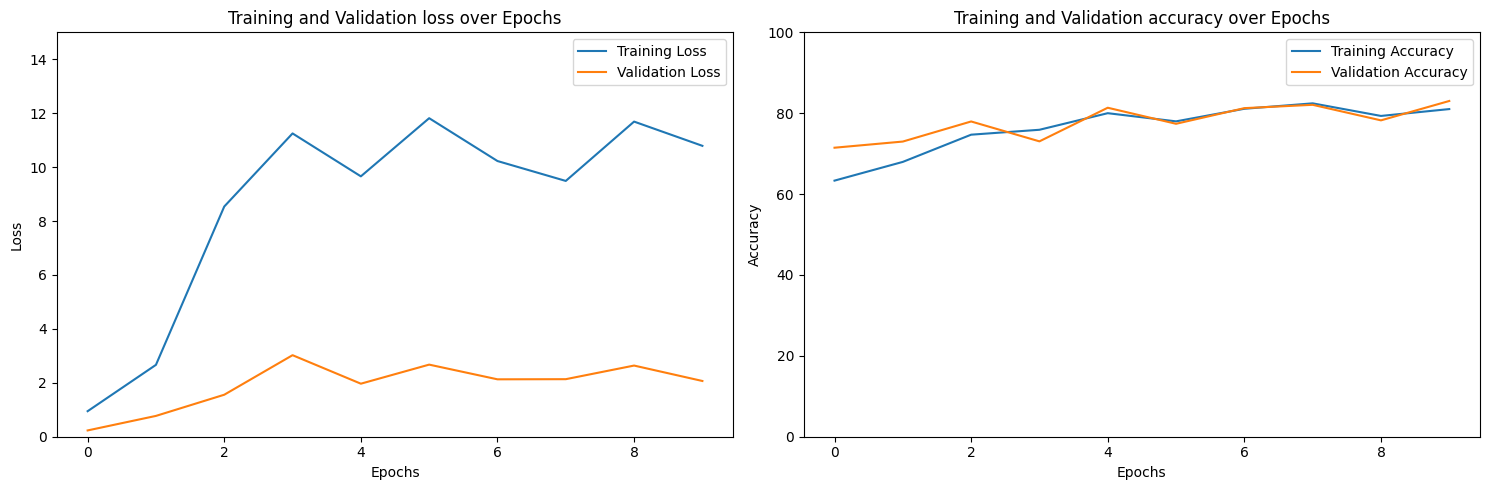

In [24]:
fig , axs = plt.subplots(nrows=1,ncols=2,figsize=(15,5))

axs[0].plot(total_loss_train_plot,label="Training Loss")
axs[0].plot(total_loss_val_plot,label="Validation Loss")
axs[0].set_title("Training and Validation loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,15])
axs[0].legend()

axs[1].plot(total_acc_train_plot,label="Training Accuracy")
axs[1].plot(total_acc_val_plot,label="Validation Accuracy")
axs[1].set_title("Training and Validation accuracy over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.tight_layout()
plt.show()